In [1]:
# Import useful packages
import os
import time
import pandas as pd
# Suppressing some warnings in pandas
pd.options.mode.chained_assignment = None
import numpy as np
import glob
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, date, time, timedelta
from ta import add_all_ta_features

# Model creation packages
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error, accuracy_score, max_error
from sklearn.model_selection import train_test_split, GridSearchCV

# Importing our self-created functions
from feature_creation import *
from portfolio import *
import port_2 as port2

# Importing packages needed to reload self-created functions when testing
import sys, importlib

# Dash modules
import dash
import dash_table
import dash_core_components as dcc
import dash_html_components as html
from jupyter_dash import JupyterDash
import plotly.express as px
import plotly.graph_objects as go

# For loading data from postgres
from sqlalchemy import create_engine
import psycopg2
from psycopg2 import connect

# Importing Financial packages used for building visualizations
from yahoo_fin import stock_info as si
import financial_metrics as fm
from port_charts import *

In [2]:
def import_technical_features():
    conn = connect(dbname = '697_temp', user = 'postgres', host = 'databasesec.cvhiyxfodl3e.us-east-2.rds.amazonaws.com', password = 'poRter!5067')
    cur = conn.cursor()
    query = "SELECT * FROM technical_features_daily"
    data = pd.read_sql_query(query,conn)
    data = data.sort_values(['ticker', 'Date'])
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.set_index('Date')
    return data
feature_df = import_technical_features()

# Or just load if no need to re-create features
# feature_df = pd.read_csv('assets/models/tyler_rf_daily_update/ta_feature_df.csv',index_col=0)

# Ensure index is datetime
# feature_df.index = pd.to_datetime(feature_df.index)

feature_df.head()

,Adj Close,Close,Close_adj,Dividends,High,High_adj,Low,Low_adj,Open,Open_adj,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,44.773853,44.773853,46.490002,0.0,45.024254,46.750000,44.051539,45.740002,44.234524,45.930000,...,-18.934957,0.652427,43.960978,1.050305,-14.557534,-14.511079,-0.046455,2.041252,2.020697,64.998080
2017-01-04,45.361336,45.361336,47.099998,0.0,45.631002,47.380001,45.091673,46.820000,45.197613,46.930000,...,-13.017484,0.759583,44.117789,1.452683,-11.329006,-13.874665,2.545658,1.312111,1.303577,67.163037
2017-01-05,44.822021,44.822021,46.540001,0.0,45.332456,47.070000,44.648666,46.360001,45.313194,47.049999,...,-39.051549,0.847551,44.131201,1.665804,-10.367377,-13.173207,2.805830,-1.188929,-1.196054,65.175587
2017-01-06,46.218483,46.218483,47.990002,0.0,46.295528,48.070000,44.841270,46.560001,44.908686,46.630001,...,-2.815870,1.128783,44.333750,5.940935,-2.581875,-11.054941,8.473066,3.115570,3.068021,70.321748
2017-01-09,46.362946,46.362946,48.139999,0.0,46.767443,48.560001,46.141436,47.910000,46.237743,48.009998,...,-12.608987,1.565163,44.559215,4.478225,1.637793,-8.516394,10.154187,0.312565,0.312077,70.854113


In [3]:
# Doing some data-preprocessing

# Filling in technical indicators with known values
feature_df = feature_df.fillna(method="ffill")
feature_df = feature_df.fillna(method="bfill")

# Some Tickers do not have adjusted prices, so setting to non-adjusted
feature_df['Close_adj'] = feature_df['Close_adj'].fillna(feature_df['Close'])
feature_df['High_adj'] = feature_df['High_adj'].fillna(feature_df['High'])
feature_df['Low_adj'] = feature_df['Low_adj'].fillna(feature_df['Low'])
feature_df['Open_adj'] = feature_df['Open_adj'].fillna(feature_df['Open'])

In [4]:
# # Used for Tyler's macbook air due to compatibility issues
# # Or just load if no need to re-create features
# feature_df = pd.read_csv('assets/models/tyler_rf_daily_update/ta_feature_df.csv',index_col=0)

# # Ensure index is datetime
# feature_df.index = pd.to_datetime(feature_df.index)

# feature_df.head()

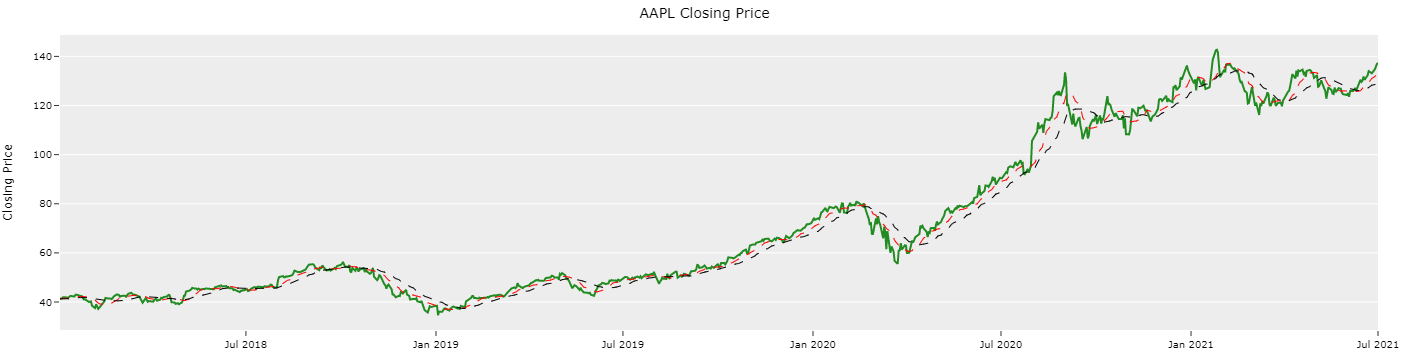

In [43]:
# Simple visualization of a ticker price over time to ensure data looks accurate
fig = go.Figure()

ticker = 'AAPL'
df = feature_df[(feature_df['ticker']==ticker)&(feature_df.index>='2018-01-01')]

fig.add_trace(go.Scatter(x=df.index,
                         y=df['Close'],
                        line={"color": "#228B22"},
                        mode="lines",
                        name='Closing Price'))

fig.add_trace(go.Scatter(x=df.index,
                         y=df['trend_sma_fast'],
                        line={"color": "red","dash":"dash","width":1},
                        mode="lines",
                        name='Closing Price'))

fig.add_trace(go.Scatter(x=df.index,
                         y=df['trend_sma_slow'],
                        line={"color": "black","dash":"dash","width":1},
                        mode="lines",
                        name='Closing Price'))

fig.update_layout(title_text=f'{ticker} Closing Price',title_x=0.5,
                         template="ggplot2",font=dict(size=10,color='black'),xaxis_showgrid=False,
                         paper_bgcolor='rgba(0,0,0,0)',
                         yaxis_title="Closing Price",margin={"r": 20, "t": 35, "l": 20, "b": 10},
                         showlegend=False)

fig.show()

## Part 1: Feature Selection
#### In this section, we train a lightly configured Random Forest Regressor to get feature importance of all features. Using this set of features, we order based on importance and only select features over a certain threshold of importance

In [44]:
# Creating sample df for AAPL only, as we train models for all tickers eventually
sample_df = feature_df[(feature_df['ticker']=='AAPL')&(feature_df.index>='2018-01-01')&\
                       (feature_df.index<='2020-12-31')]

# Creating target variables to look at performance in forecasting at different time horizons
sample_df['target_7'] = sample_df['Close_adj'].shift(-7)
sample_df['target_30'] = sample_df['Close_adj'].shift(-30)
sample_df['target_60'] = sample_df['Close_adj'].shift(-60)
sample_df['target_120'] = sample_df['Close_adj'].shift(-120)

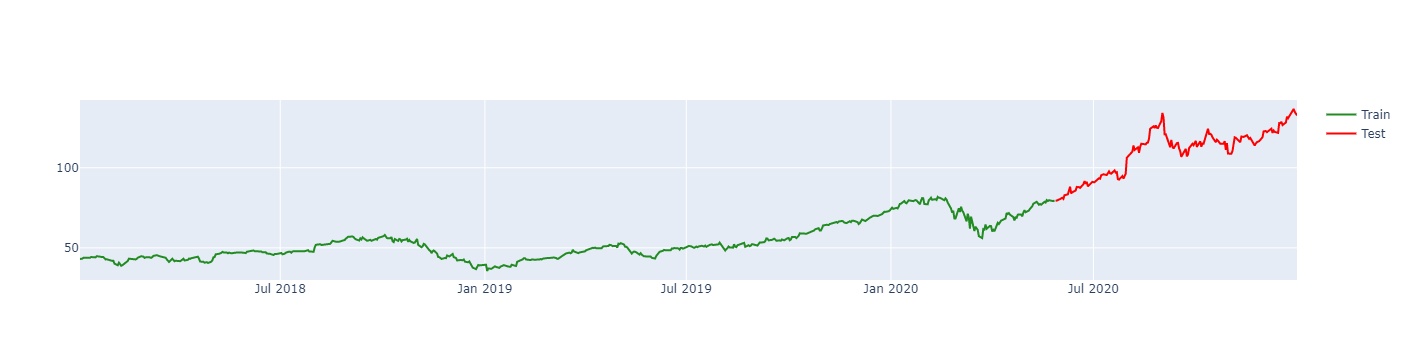

In [45]:
# Test Train split, ensuring data looks correct
split_perc = .8
train_df = sample_df.iloc[:int(len(sample_df)*split_perc)]
test_df = sample_df.iloc[int(len(sample_df)*split_perc):]

# Ensuring the test/train split worked correctly
fig = go.Figure()

fig.add_trace(go.Scatter(x=train_df.index,
                         y=train_df['Close_adj'],
                        line={"color": "#228B22"},
                        mode="lines",
                        name='Train'))

fig.add_trace(go.Scatter(x=test_df.index,
                         y=test_df['Close_adj'],
                        line={"color": "red"},
                        mode="lines",
                        name='Test'))

In [46]:
# Get actual feature columns from train_df
features = list(train_df.columns)[15:len(train_df.columns)-4]
features.extend(['Adj Close','High_adj','Low_adj','Open_adj'])

In [47]:
# Training our initial RF Reg model
X = train_df[features]
y = train_df['target_7']

# If scaling is needed
# scaler = StandardScaler()
# X_Scaled = scaler.fit_transform(X)

# Using a Random Forest Regressor to test time horizon predictions
regr = RandomForestRegressor(max_depth=5, random_state=0)

regr.fit(X, y)

RandomForestRegressor(max_depth=5, random_state=0)

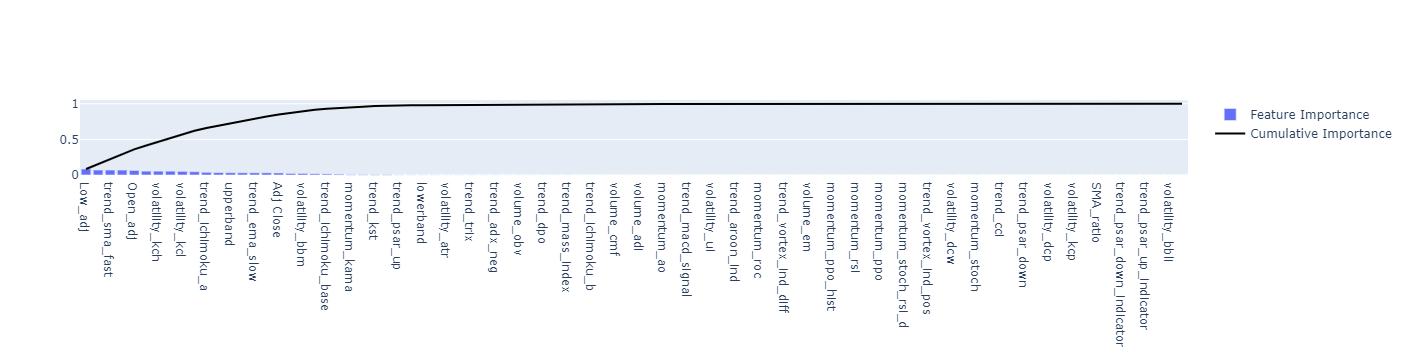

In [48]:
# Plotting feature importance. Vast majority of features seem to be of no use to the model, so will drop
fig = go.Figure()

feats = [x for _, x in sorted(zip(regr.feature_importances_,features),reverse=True)]
importance = sorted(regr.feature_importances_,reverse=True)

fig.add_trace(go.Bar(x=feats, y=importance,name="Feature Importance"))

fig.add_trace(go.Scatter(x=feats,
                         y=np.cumsum(sorted(regr.feature_importances_,reverse=True)),
                         line={"color":"black"},
                         mode="lines",
                         name="Cumulative Importance"
                        ))

fig.show()

In [49]:
# Getting only features that are important up to a threshold, and directionally adding 2%+
thresh = .9
thresh_len = len([x for x in np.cumsum(sorted(regr.feature_importances_,reverse=True)) if x <= thresh])

# Using this loop to ensure features we keep are adding substantial value
[x for x in np.cumsum(sorted(regr.feature_importances_,reverse=True)) if x <= thresh]

[0.08453112639998188,
 0.15512932921360306,
 0.22514085670600542,
 0.2950794899515831,
 0.3596083403431524,
 0.4144087357694752,
 0.4690750092365454,
 0.5234694695830443,
 0.575300409108591,
 0.6220675129044686,
 0.6606675225231645,
 0.6947222448118376,
 0.7270720821658124,
 0.7585888658158788,
 0.789707820622331,
 0.820748293735024,
 0.8500282130901614,
 0.8733337163620454,
 0.8963818980915682]

## Part 2: Exploring Target Variables
#### We are going to explore model prediction capabilities by training 4 models tasked with predicting future price over some time horizon (7, 30, 60, 120 days), which will tell us if we should be buying or selling to take advantage of price changes

In [62]:
# Including all features under importance threshold
updated_feats = feats[:thresh_len+1]

# Re-training model with smaller subset of features
regr = RandomForestRegressor(max_depth=10, n_estimators= 100, random_state=0)

X = train_df[updated_feats]
y = train_df['target_7']

# If scaling is needed
# X_Scaled = scaler.fit_transform(X)

regr.fit(X, y)

feat_importance_7 = regr.feature_importances_
r2_7 = np.round(regr.score(X,y),4)

# R^2 is very high. This model is most likely highly overfit
print(f'R^2 for Model: {np.round(regr.score(X,y),4)}')

R^2 for Model: 0.9972


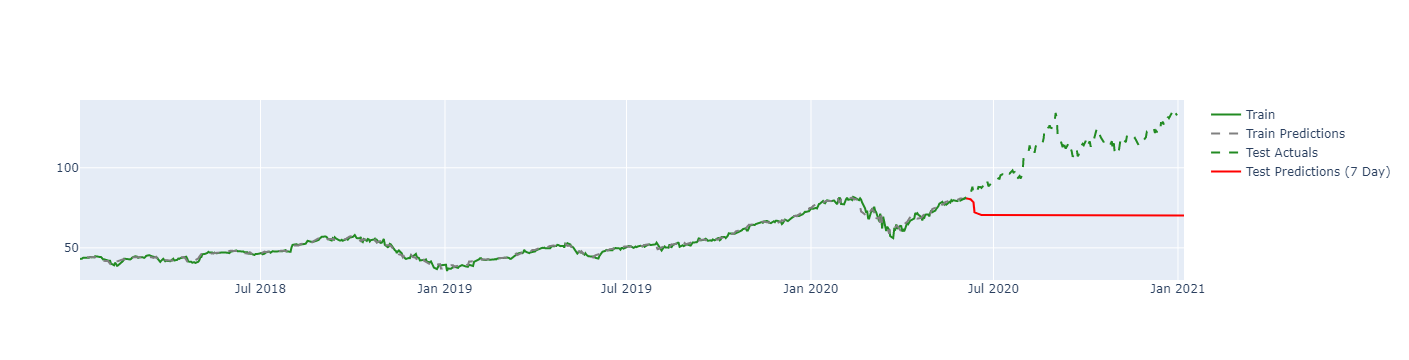

In [63]:
# Creating our train data points from predicting our target
train_predictions = regr.predict(X)

X_test = test_df[updated_feats]

# If scaling is needed
# X_test_scaled = scaler.fit_transform(test_df[updated_feats])

# Creating our test data points from predicting our target
test_predictions = regr.predict(X_test)

fig = go.Figure()

fig.add_trace(go.Scatter(x=train_df.index,
                         y=train_df['Close_adj'],
                        line={"color": "#228B22"},
                        mode="lines",
                        name='Train'))

fig.add_trace(go.Scatter(x=train_df.index+timedelta(days=7),
                         y=train_predictions,
                        line={"color": "gray","dash":"dash"},
                        mode="lines",
                        name='Train Predictions'))

fig.add_trace(go.Scatter(x=test_df.index,
                         y=test_df['Close_adj'],
                        line={"color": "#228B22","dash":"dash"},
                        mode="lines",
                        name='Test Actuals'))

fig.add_trace(go.Scatter(x=test_df.index+timedelta(days=7),
                         y=test_predictions,
                        line={"color": "red"},
                        mode="lines",
                        name='Test Predictions (7 Day)'))

#### Observations:
1. Looking at prediction performance. So far, our model does a horrible job at predicting the future
2. Will look into some thresholding on price projections/ROI to making buying/selling decisions
3. Why does scaling not work?

#### Adding additional models with longer targets

R^2 for Model: 0.9614


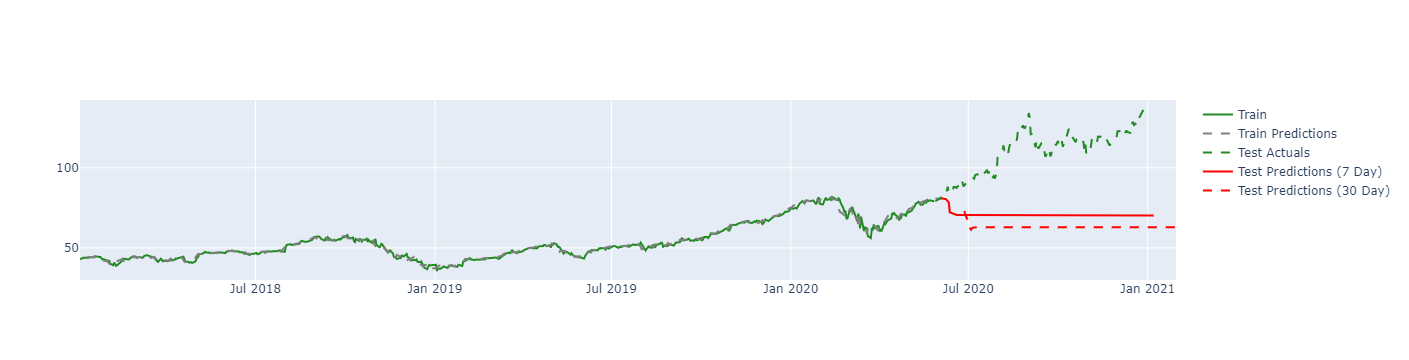

In [64]:
# Training a model on 30_Day
regr = RandomForestRegressor(max_depth=5, random_state=0)

X = train_df[updated_feats]
y = train_df['target_30']

regr.fit(X, y)

feat_importance_30 = regr.feature_importances_
r2_30 = np.round(regr.score(X,y),4)

print(f'R^2 for Model: {np.round(regr.score(X,y),4)}')

test_predictions = regr.predict(test_df[updated_feats])

fig.add_trace(go.Scatter(x=test_df.index+timedelta(days=30),
                         y=test_predictions,
                        line={"color": "red","dash":"dash"},
                        mode="lines",
                        name='Test Predictions (30 Day)'))

R^2 for Model: 0.9401


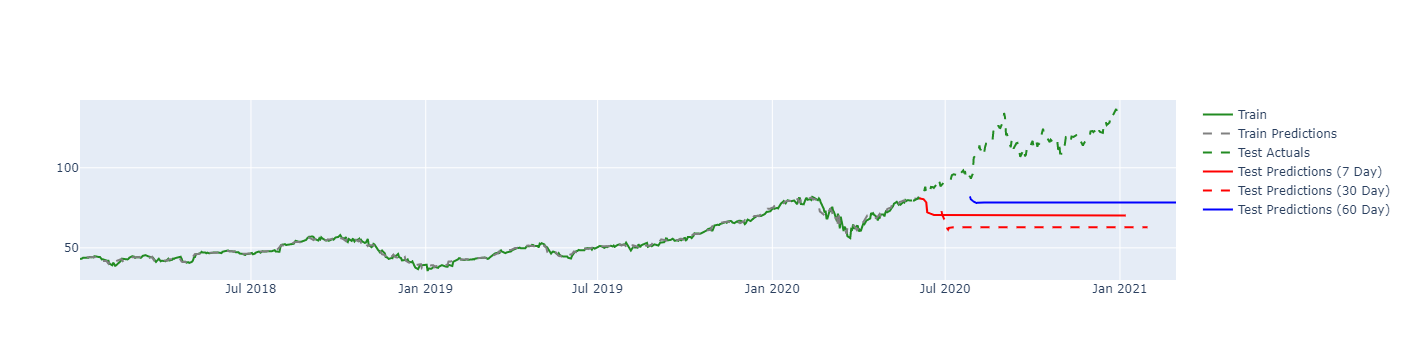

In [65]:
# Training a model on 60_Day
regr = RandomForestRegressor(max_depth=5, random_state=0)

X = train_df[updated_feats]
y = train_df['target_60']

regr.fit(X, y)

feat_importance_60 = regr.feature_importances_
r2_60 = np.round(regr.score(X,y),4)

# R^2 is very high. This model is most likely highly overfit
print(f'R^2 for Model: {np.round(regr.score(X,y),4)}')

test_predictions = regr.predict(test_df[updated_feats])

fig.add_trace(go.Scatter(x=test_df.index+timedelta(days=60),
                         y=test_predictions,
                        line={"color": "blue"},
                        mode="lines",
                        name='Test Predictions (60 Day)'))

R^2 for Model: 0.9676


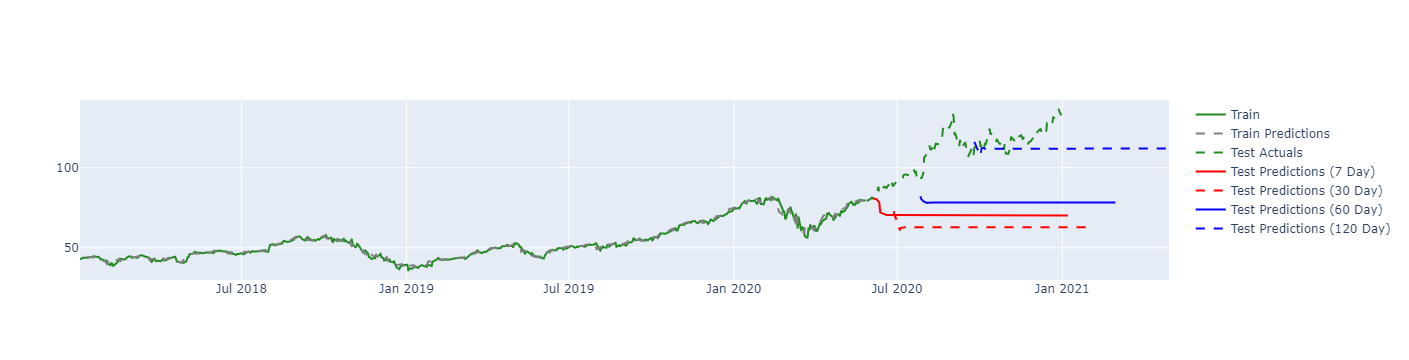

In [66]:
# Training a model on 120_Day
regr = RandomForestRegressor(max_depth=5, random_state=0)

X = train_df[updated_feats]
y = train_df['target_120']

regr.fit(X, y)

feat_importance_120 = regr.feature_importances_
r2_120 = np.round(regr.score(X,y),4)

# R^2 is very high. This model is most likely highly overfit
print(f'R^2 for Model: {np.round(regr.score(X,y),4)}')

test_predictions = regr.predict(test_df[updated_feats])

fig.add_trace(go.Scatter(x=test_df.index+timedelta(days=120),
                         y=test_predictions,
                        line={"color": "blue","dash":"dash"},
                        mode="lines",
                        name='Test Predictions (120 Day)'))

<AxesSubplot:>

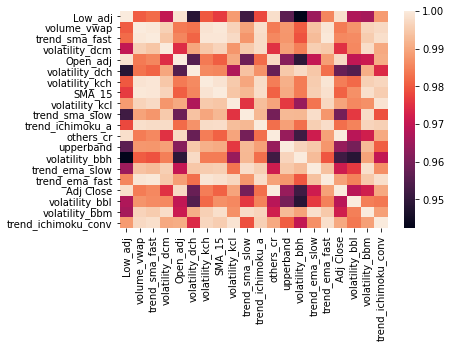

In [67]:
import seaborn as sns
# Looking at correlation between features, we have quite high correlation between all
corr = train_df[updated_feats].corr()

sns.heatmap(corr)

In [61]:
[x for _, x in sorted(zip(feat_importance_7,updated_feats),reverse=True)]

['Low_adj',
 'trend_sma_fast',
 'Open_adj',
 'volatility_kch',
 'volatility_bbh',
 'volatility_dch',
 'volume_vwap',
 'trend_ema_slow',
 'trend_ema_fast',
 'others_cr',
 'SMA_15',
 'upperband',
 'trend_sma_slow',
 'volatility_bbm',
 'volatility_kcl',
 'Adj Close',
 'trend_ichimoku_conv',
 'volatility_dcm',
 'volatility_bbl',
 'trend_ichimoku_a']

<b>Observations:</b>
1. Fairly high correlation between all features, but that's expected as features are all calculated based on some price or volume change behavior
2. We could use a smaller subset of manually determined, less correlated features. Or, we could manually engineer new features based on commonly used technical indicators (such as the "death cross", where the short term MA (typically 50 days) goes below the long term moving average (typically 200 days)

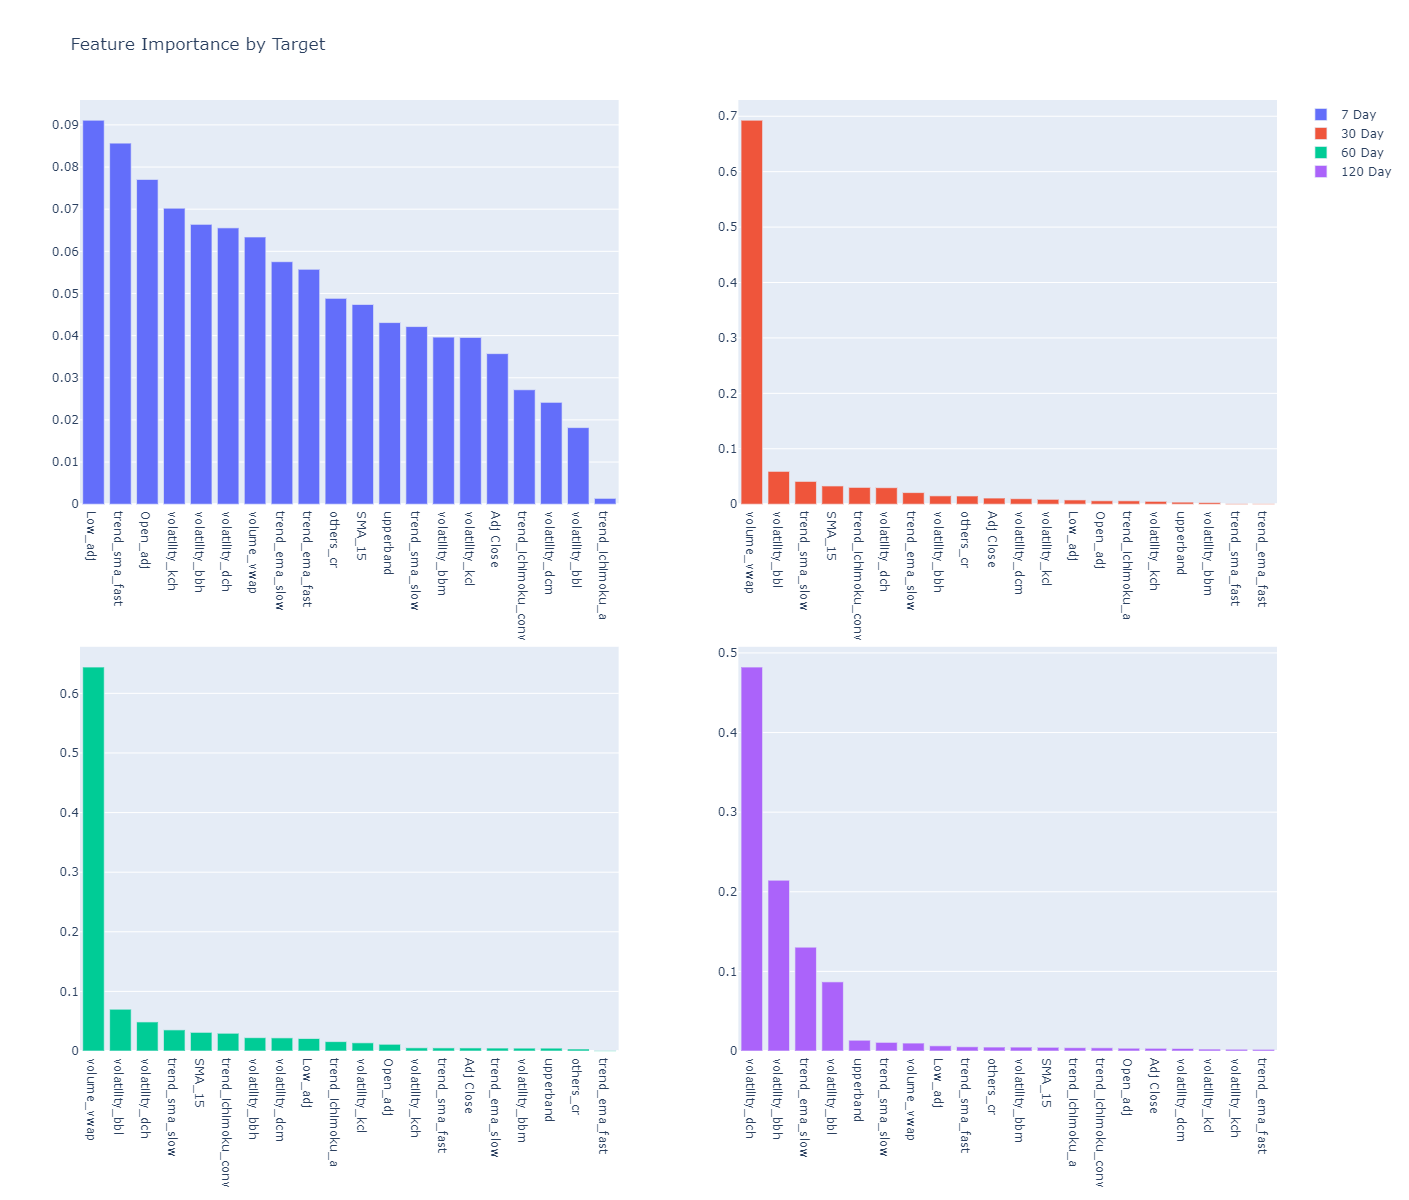

In [94]:
from plotly.subplots import make_subplots
fig2 = make_subplots(rows=2, cols=2)

# Adding features by importance for 7 day model
feats_7 = [x for _, x in sorted(zip(feat_importance_7,updated_feats),reverse=True)]
importance_7 = sorted(feat_importance_7,reverse=True)


fig2.add_trace(
    go.Bar(x=feats_7, y=importance_7,name='7 Day'),
    row=1, col=1
)

# Adding features by importance for 30 day model
feats_30 = [x for _, x in sorted(zip(feat_importance_30,updated_feats),reverse=True)]
importance_30 = sorted(feat_importance_30,reverse=True)
fig2.add_trace(
    go.Bar(x=feats_30, y=importance_30,name='30 Day'),
    row=1, col=2
)

# Adding features by importance for 60 day model
feats_60 = [x for _, x in sorted(zip(feat_importance_60,updated_feats),reverse=True)]
importance_60 = sorted(feat_importance_60,reverse=True)
fig2.add_trace(
    go.Bar(x=feats_60, y=importance_60,name='60 Day'),
    row=2, col=1
)

# Adding features by importance for 60 day model
feats_120 = [x for _, x in sorted(zip(feat_importance_120,updated_feats),reverse=True)]
importance_120 = sorted(feat_importance_120,reverse=True)
fig2.add_trace(
    go.Bar(x=feats_120, y=importance_120,name='120 Day'),
    row=2, col=2
)

fig2.update_layout(height=1200, width=1000, title_text="Feature Importance by Target")
fig2.show()

#### Observations:
1. Every model does a fairly good job of predicting the first data point forecasted in the future, but performance drops off significantly from there
2. Also, our train predictions all have R^2 around or greater than 96%, which is common for Random Forest models, that can have a tendency to overfit
3. Interesting enough, all models have variation in what features they think are important, and the 7 day model has a greater didstribution of technical features with similar importance
4. What objective function should I actually be using?
5. Should I weight predictions and decisions based on model backtesting performance?

## Part 2b: Perform GridSearch to Find Best Model Configuration
#### GridSearch will be performed to look for optimal model configuration. This can also help limit compute time, by allowing you to find a less compute intense model upfront (e.g. n_estimators = 500 takes substantially more time to train that n_estimators = 100)

In [95]:
def pipeline(X, y):
    """Trains, tests, and evaluates classification model using GridSearch"""
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    param_grid = {'n_estimators': [100, 200, 500],
              'max_depth': [5, 10, 15],
              "max_features": ['auto', 'sqrt', 'log2'],
              "criterion": ['mse', 'mae']}
    scorers = {
        'mse': make_scorer(mean_squared_error),
        'max_error' : make_scorer(max_error)
    }

    etc = RandomForestRegressor(random_state=0,n_jobs=-1)
    clf = GridSearchCV(etc, param_grid=param_grid, cv=3, refit='mse',
                       return_train_score=True, scoring=scorers)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    t = clf.best_params_
    print(t)

    results = pd.DataFrame(clf.cv_results_)
#     results.to_csv('mod_1_gsresults.csv')
    return t, X_train, X_test, y_train, y_test, clf, results

In [97]:
# Determine best params
t, X_train, X_test, y_train, y_test, clf, cv_results = pipeline(train_df[updated_feats], train_df['target_30'])

### Creating Dataframes of model metrics for AAPL

In [117]:
# Savings model performance to file
target_list = ['target_7','target_60','target_120']
feat_lists = []
r2_list = []

for item in target_list:

    regr = RandomForestRegressor(max_depth=5,n_estimators=100,criterion='mae',max_features='sqrt',random_state=0)
    regr.fit(train_df[updated_feats],train_df[item])
    
    feat_importance = list(regr.feature_importances_)
    r2 = np.round(regr.score(train_df[updated_feats],train_df[item]),4)
    
    feat_lists.append(feat_importance)
    r2_list.append(r2)


In [122]:
r2_list

[0.9831, 0.9115, 0.9448]

In [123]:
feat_df = pd.DataFrame(data=feat_lists,
                        index=['Target 7','Feats 60','Target 120']).transpose()

feat_df['Features'] = updated_feats
# r2 = pd.DataFrame(data=[r2_7,r2_60,r2_120],index=['r2 7','r2 60','r2 120'],columns=['R2 Score'])

feat_df.head()

,Target 7,Feats 60,Target 120,Features
0,0.072086,0.014207,0.011318,Low_adj
1,0.051014,0.106940,0.021173,volume_vwap
2,0.070964,0.022971,0.020407,trend_sma_fast
3,0.024271,0.053891,0.036147,volatility_dcm
4,0.061886,0.016610,0.011936,Open_adj


In [136]:
feat_df[['Target 7','Features']].sort_values(by='Target 7',ascending=False)

,Target 7,Features
11,0.074785,others_cr
0,0.072086,Low_adj
2,0.070964,trend_sma_fast
18,0.063688,volatility_bbm
8,0.062483,volatility_kcl
4,0.061886,Open_adj
6,0.060880,volatility_kch
16,0.056663,Adj Close
19,0.055233,trend_ichimoku_conv
1,0.051014,volume_vwap


In [127]:
r2_df = pd.DataFrame(data=r2_list,columns=['r2'],index=['Target 7','Feats 60','Target 120']).transpose()

In [130]:
# Saving all dfs to file
feat_df.to_csv('assets/models/tyler_rf_daily_update/feature_importance.csv')
r2_df.to_csv('assets/models/tyler_rf_daily_update/r2_df.csv')
corr.to_csv('assets/models/tyler_rf_daily_update/corr.csv')

## Part 3: Using past knowledge to re-train our model
#### Given we see every first point we predict is much more aligned to actual test data, we will explore an approach that will allow us to re-train the model every day once we have additional info

In [22]:
new_train_df = train_df
test_preds = []
test_dates = []

# Need to remove last 7 observations due to missing price for 7 days in the future
for i in range(len(test_df)-7):

    # Creating next prediction point
    test_point = test_df[updated_feats].iloc[[i]]

    X = new_train_df[updated_feats]
    y = new_train_df['target_7']

    regr = RandomForestRegressor(max_depth=5,n_estimators=100,criterion='mae',max_features='sqrt',random_state=0)

    regr.fit(X, y)

    test_prediction = regr.predict(test_point)[0]
    test_date = test_point.index.values[0]

    test_preds.append(test_prediction)
    test_dates.append(test_date)
    
    # Adding next observation to our training data to simulate re-training a model daily
    new_train_df = pd.concat([new_train_df,test_df.iloc[[i]]])
    
# Adding the final predictions for obersavtions without the target variable
for i in range(len(test_df)-7,len(test_df)):
    
    test_point = test_df[updated_feats].iloc[[i]]
    
    test_prediction = regr.predict(test_point)[0]
    test_date = test_point.index.values[0]
    
    test_preds.append(test_prediction)
    test_dates.append(test_date)

In [23]:
# Creating DF with new preds to allow for easy plotting
new_test_df = pd.DataFrame(data=test_preds,index=test_dates,columns=['7_Day'])

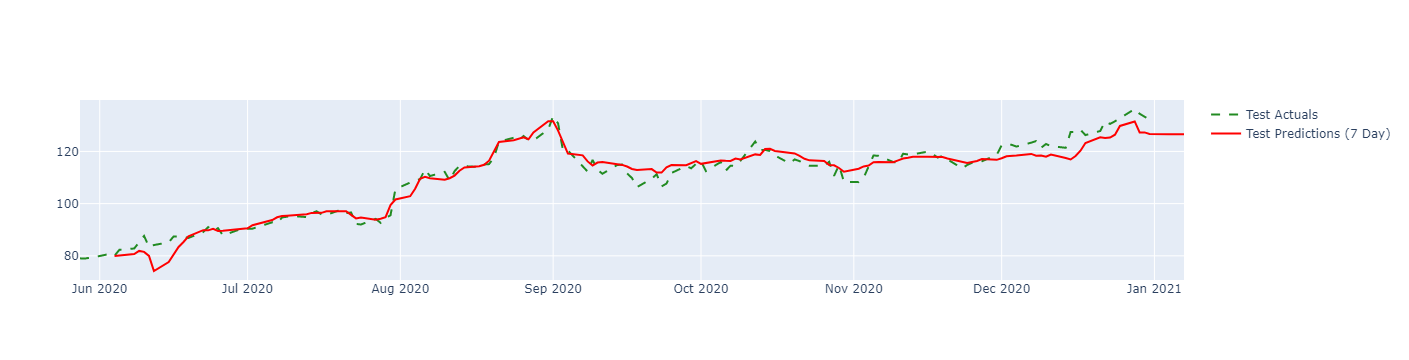

In [24]:
# Plotting our new re-fitted predictions with test data
# Fit is much more appropriate...why??
fig = go.Figure()

fig.add_trace(go.Scatter(x=test_df.index,
                         y=test_df['Close'],
                        line={"color": "#228B22","dash":"dash"},
                        mode="lines",
                        name='Test Actuals'))

fig.add_trace(go.Scatter(x=new_test_df.index+timedelta(days=7),
                         y=new_test_df['7_Day'],
                        line={"color": "red"},
                        mode="lines",
                        name='Test Predictions (7 Day)'))

#### Observations:
1. As expected, re-training our model daily provides much better accuracy for making predictions into the future, as we are able to incorporate new information for each model build
2. I believe this is true given we are able to minimize the effects of the "random walk" theory commonly attributed to stock market price movements. We are also able to better minimize the effects of exogenous or econmomic factors that actually lead to more concrete changes in stock prices

## Part 4: Picking a subset of tickers and creating models for each
#### In this section, we will make assumptions about tickers and their performance (based on research/tribal knowledge) and build models for each to allow us to start to create a diversified portfolio

In [25]:
# Could pick tickers with lowest industry P/E ratios, but for now only picking popular stocks
# getting all sectors to get largest tickers by volume
sectors = list(feature_df.sector.unique())

# Creating function to get largest tickers for a sector
def largest_tickers_by_vol(sector):
    return list(feature_df[feature_df['sector']==sector].groupby('ticker').mean('Volume')['Volume'].nlargest(5).index.values)

tickers = []

for sector in sectors:
    tickers.extend(largest_tickers_by_vol(sector))

tickers[:10]

['PFE', 'BMY', 'MRK', 'GILD', 'CVS', 'GE', 'AAL', 'CSX', 'DAL', 'UAL']

In [19]:
# Setting these manually so I dont have to re-run the rest of the notebook
updated_feats = ['Low_adj','trend_sma_fast','Open_adj','volatility_kch','volatility_bbh','volatility_dch',
 'volume_vwap','trend_ema_slow','trend_ema_fast','others_cr','SMA_15','upperband','trend_sma_slow',
 'volatility_bbm','volatility_kcl','Adj Close','trend_ichimoku_conv','volatility_dcm','volatility_bbl',
 'trend_ichimoku_a']

In [27]:
# Define function to fit a model that predicts price performance over some time horizon
def fit_model(ticker,train_start_dt,train_end_dt,target=7):

    # Creating sample df for ticker only
    sample_df = feature_df[(feature_df['ticker']==ticker)&(feature_df.index>=train_start_dt)&\
                           (feature_df.index<=train_end_dt)]#.fillna(method="ffill")

    # *************Will remove once I confirm not needed********
#     # Backfilling if forward filling didn't work
#     sample_df = sample_df.fillna(method="bfill")
    
#     # Some Tickers do not have adjusted prices, so setting to non-adjusted
#     sample_df['Close_adj'] = sample_df['Close_adj'].fillna(sample_df['Close'])
#     sample_df['Close_adj'] = sample_df['Close_adj'].fillna(sample_df['Close'])

    # Creating target variable to predict prices X days in future
    sample_df[f'target_{target}'] = sample_df['Close_adj'].shift(-1*target)

    # Dropping 7 most recent dates given there is no prediction
    train_df = sample_df.dropna()

    # Fitting my model on inital train_df
    X = train_df[updated_feats]
    y = train_df[f'target_{target}']

    regr = RandomForestRegressor(max_depth=5,n_estimators=100,criterion='mae',max_features='sqrt',random_state=0)
    regr.fit(X, y)

    # Getting trading days calendar to add prediction to N trading days in future
    nyse = mcal.get_calendar('NYSE')
    train_end_dt_for_cal = datetime.strptime(train_end_dt,"%Y-%m-%d")
    valid_days = list(nyse.valid_days(start_date=train_end_dt_for_cal, end_date=train_end_dt_for_cal+timedelta(days=target+120)))

    # Getting X trading days in future
    test_date = valid_days[target].strftime('%Y-%m-%d')
    test_prediction = regr.predict(sample_df[updated_feats].iloc[[-1]])[0]

    return test_date, test_prediction, regr

In [28]:
# Testing out our function with one model creation for AAPL
fit_model('AAL','2016-01-01','2020-05-28')

('2020-06-08',
 10.469149904251099,
 RandomForestRegressor(criterion='mae', max_depth=5, max_features='sqrt',
                       random_state=0))

In [32]:
# Putting everything above together
# This will assess prices and predictions every 7 days and change positions accordingly

# Setting training dates. Will test on all data after
train_start_dt = '2018-01-01'

# Filtering to new_df just with dates we care about
new_df = feature_df[feature_df.index >=train_start_dt]

# Creating train_df and test_df
split_perc = .8
# Getting index values needed to split df
train_int = int(len(new_df.index.unique())*split_perc)

# Splitting new_df into train_df and test_df
train_df = new_df[new_df.index.isin(new_df.index.unique()[:train_int])]
test_df = new_df[new_df.index.isin(new_df.index.unique()[train_int:])]

train_end_dt = pd.to_datetime(new_df[new_df.index.isin(new_df.index.unique()[:train_int])]\
                              .index.max()).date().strftime('%Y-%m-%d')

# Initializing portfolio
# start_dt = test_df.index.min().strftime('%Y-%m-%d')
test = port2.portfolio(start_date='2018-01-01', value=100000, end_date='2021-07-30')

ticker_preds = pd.DataFrame(columns=['ticker','pred_date','pred_price','curr_dt','curr_price','earn_ratio'])

iteration = 0

# Setting configuration variables
target = 7
rebal_interval = 7

for i in range(0,len(test_df.index.unique()),rebal_interval):

    # Changing train end date for every iteration, first iteration will be current train_end_dt
    next_train_end_dt = (pd.to_datetime(train_end_dt)+timedelta(i)).strftime('%Y-%m-%d')
    
#     # Getting available trading days
#     nyse = mcal.get_calendar('NYSE')
#     train_end_dt_for_cal = datetime.strptime(next_train_end_dt,"%Y-%m-%d")
    
#     # Finding available trading days up to 10 days in future
#     valid_days = list(nyse.valid_days(start_date=train_end_dt_for_cal, end_date=train_end_dt_for_cal+timedelta(days=10)))
    
    # Getting first available trading day
#     trade_day = valid_days[0].strftime("%Y-%m-%d")
    
    # Getting last trading day from training data to trade at end of day
    trade_day = new_df[new_df.index<=next_train_end_dt].index[-1].strftime("%Y-%m-%d")

    # Re-fit every ticker model and predict price in the future
    for ticker in tickers:
        
        try: # Try/except is needed for tickers without data

            pred_date, pred_price, model = fit_model(ticker,train_start_dt,next_train_end_dt,target=target)

            # Get current price on last train dt, which is when we would buy stock
            curr_price = test.get_price(date=trade_day,ticker=ticker)
            earn_ratio = pred_price / curr_price - 1

            ticker_preds = ticker_preds.append({'ticker':ticker,'pred_date':pred_date,'pred_price':pred_price,\
                        'curr_dt':next_train_end_dt,'curr_price':curr_price,'earn_ratio':earn_ratio},ignore_index=True)

        except Exception as e:
            print(e)
            print(ticker)
            pass

    # Creating dictinary of stocks and positions to sell
    try:
        sell_dict = create_sell_dict(ticker_preds[ticker_preds['pred_date']==pred_date],test.open_positions_df,\
                                                         sell_threshold = -0.05)
        print(f'Current Selected Sells: {sell_dict} for {trade_day}')

        # Selling positions of stocks predicted to decline on first available day of training (EOD)
        
        test.execute_trades(sell_dict,trade_day,'Sell')

    # If no sells exist, then pass
    except Exception as e:
        print(e)
        pass

    # Creating dictinary of stocks and positions to buy
    try:
        buy_dict = create_buy_dict(ticker_preds[ticker_preds['pred_date']==pred_date],test.current_cash,\
                                                                                   buy_threshold=0.05)
        print(f'Current Selected Buys: {buy_dict} for {trade_day}')

        # Buying positions of stocks predicted to increase on day of training (EOD)
        test.execute_trades(buy_dict,trade_day,'Buy')

    # If no buying exists, then pass
    except Exception as e:
        print(e)
        pass

    iteration+=1

    print(f'Current Progress: {iteration} out of {int(len(test_df.index.unique())/rebal_interval)+1}')

    # Adding a break point for testing
#     if iteration >= 10:
#         break


Current Selected Sells: {} for 2020-10-16
Current Selected Buys: {'PEAK': 2583, 'MRO': 1260, 'T': 152, 'WFC': 149, 'KIM': 304, 'CCL': 207, 'MO': 66, 'XOM': 66, 'GILD': 32, 'INTC': 34, 'C': 40, 'SPG': 27, 'MRK': 19} for 2020-10-16
Order to BUY 2583 shares of PEAK validated and approved
Order to BUY 1260 shares of MRO validated and approved
Order to BUY 152 shares of T validated and approved
Order to BUY 149 shares of WFC validated and approved
Order to BUY 304 shares of KIM validated and approved
Order to BUY 207 shares of CCL validated and approved
Order to BUY 66 shares of MO validated and approved
Order to BUY 66 shares of XOM validated and approved
Order to BUY 32 shares of GILD validated and approved
Order to BUY 34 shares of INTC validated and approved
Order to BUY 40 shares of C validated and approved
Order to BUY 27 shares of SPG validated and approved
Order to BUY 19 shares of MRK validated and approved
Trades Executed
Current Progress: 1 out of 26
Current Selected Sells: {} fo

In [45]:
test.open_positions_df

,Date,Ticker,Quantity,Basis,Purchase Price,Current Value,Last,% Gain
0,2020-10-16,PEAK,2591,68082.814523,26.276656,71303.800794,27.519800,4.73
1,2020-10-16,MRO,1260,5166.057860,4.100046,5262.531568,4.176612,1.87
2,2020-10-16,T,152,4027.262021,26.495145,4039.009834,26.572433,0.29
3,2020-10-16,WFC,149,3382.477718,22.701193,3290.928736,22.086770,-2.71
4,2020-10-16,KIM,304,3255.357369,10.708412,3101.502662,10.202311,-4.73
5,2020-10-16,CCL,207,2906.797504,14.042500,2873.677486,13.882500,-1.14
6,2020-10-16,MO,66,2486.702617,37.677312,2335.823080,35.391259,-6.07
7,2020-10-16,XOM,66,2139.068563,32.410130,2063.649044,31.267410,-3.53
8,2020-10-16,GILD,32,1928.129649,60.254052,1832.299815,57.259369,-4.97
9,2020-10-16,INTC,34,1806.156845,53.122260,1525.146917,44.857262,-15.56


In [35]:
tr = test.track_record
tr['Date'] = pd.to_datetime(tr['Date'])
tr

,Date,Value,Val_ex_cash
0,2020-10-16,100000.000000,99750.102856
1,2020-10-19,99135.129159,98885.232015
2,2020-10-20,99358.561924,99108.664780
3,2020-10-21,99848.186714,99598.289570
4,2020-10-22,102340.733796,102090.836653
...,...,...,...
114,2021-04-01,137499.704340,137470.672790
115,2021-04-05,138407.922747,138378.891197
116,2021-04-06,138135.587747,138106.556197
117,2021-04-07,138814.062877,138785.031327


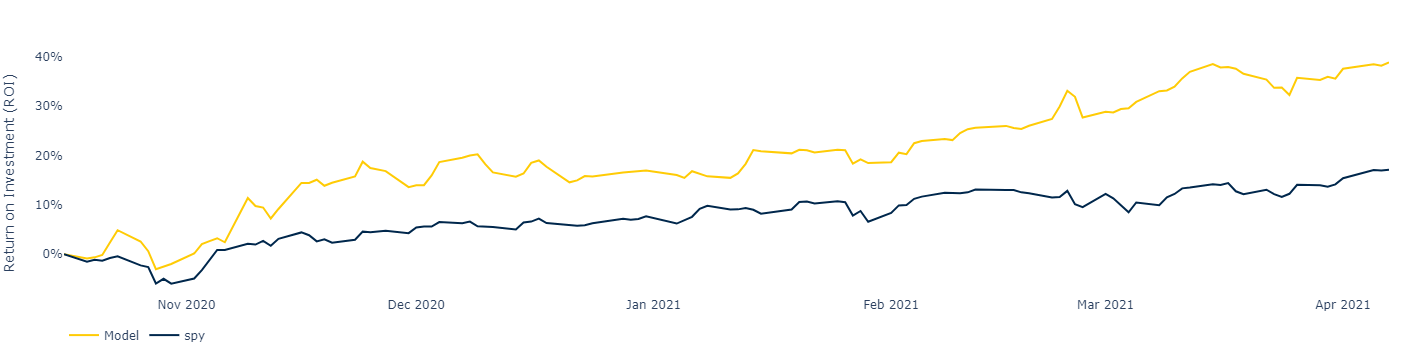

In [36]:
performance_chart(tr, 'spy')

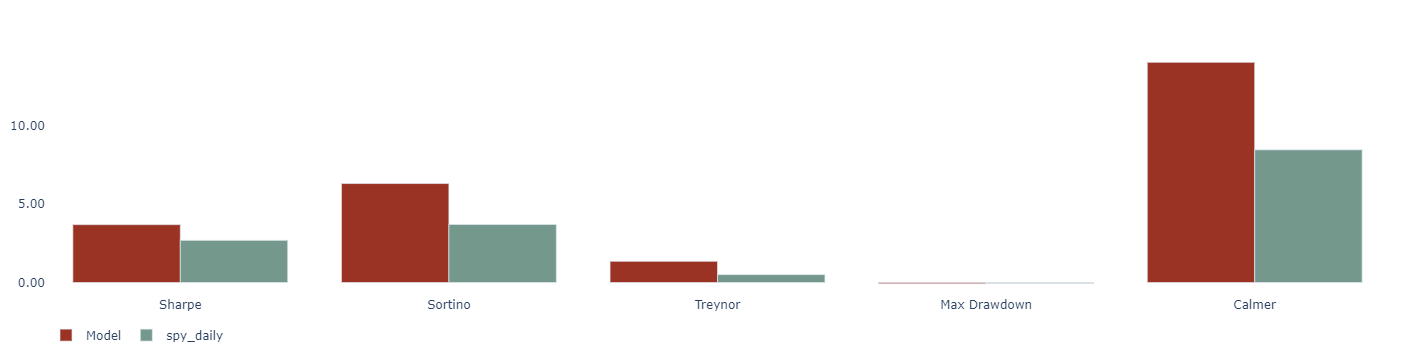

In [37]:
risk_adjusted_metrics(tr, 'spy')

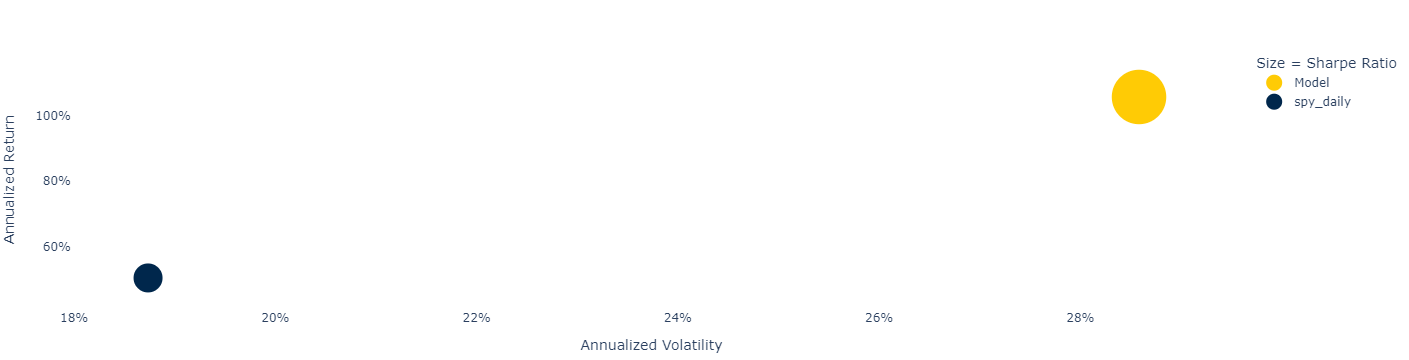

In [38]:
risk_to_ret(tr, 'spy')

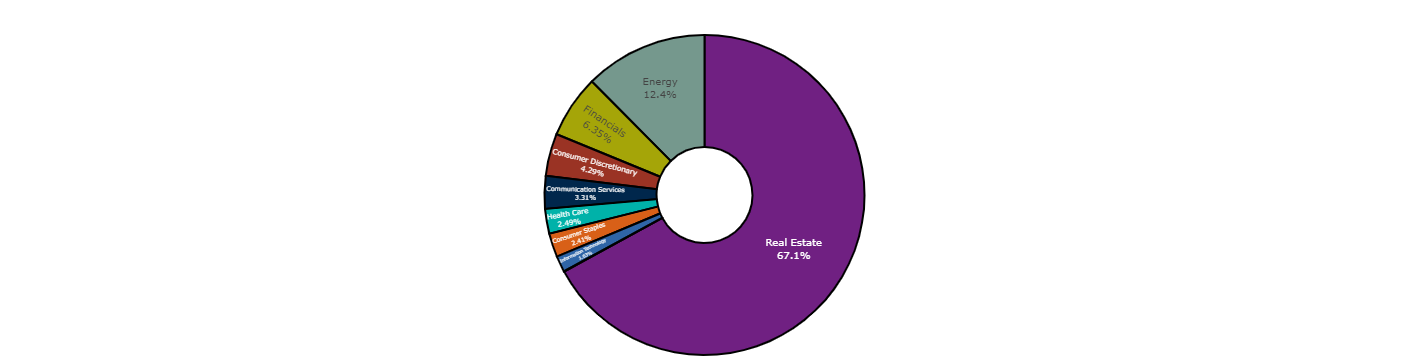

In [60]:
sector_plot(test.snapshots['Positions_2021-04-08'],test.snapshots['cash_2021-04-08'],date='2021-04-08')

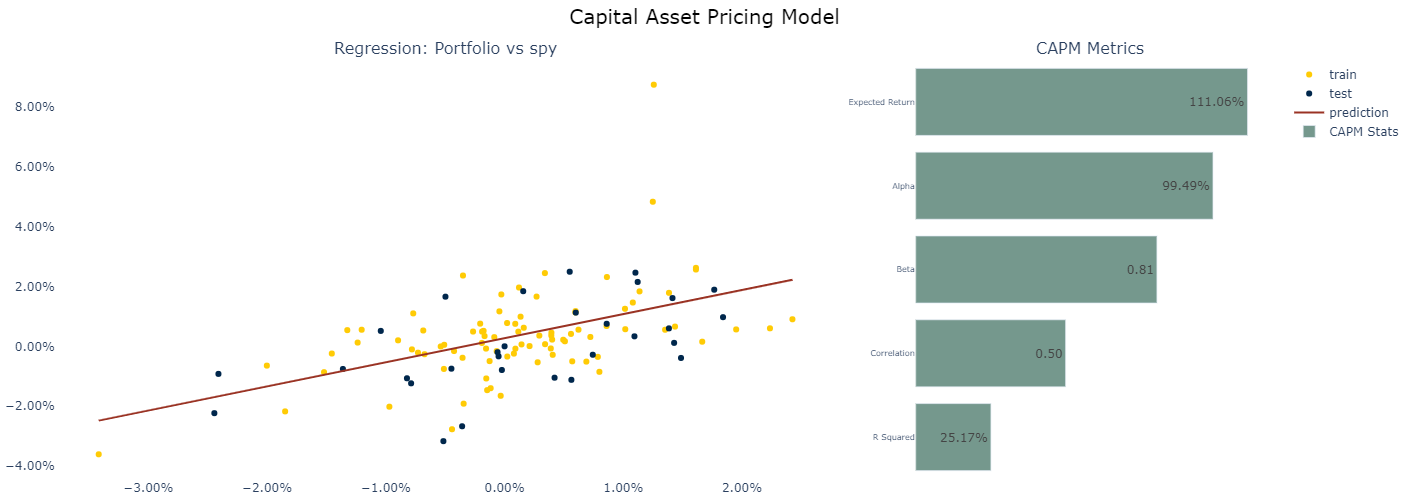

In [44]:
capm_res(tr, 'spy')

In [61]:
run_df = pd.DataFrame(columns=['model_name','model','track_record','snapshots'])

In [29]:
# "grid search" configuration for testing different portfolio constructions
gridsearch_config = [(7,7,'2017-01-01')]
    
#     (7,7,'2017-01-01')]

# Gridsearch for shorter duration does not work, maybe due to dates aren't long enough?
# [(120,30,'2016-01-01'),(120,60,'2016-01-01')] (120,30,'2017-01-01'),(120,60,'2017-01-01')

# [(7,7,'2016-01-01'),(7,30,'2016-01-01'),(7,7,'2014-01-01'),(7,30,'2014-01-01'),\
# (30,7,'2016-01-01'),(30,30,'2016-01-01'),(30,7,'2014-01-01'),(30,30,'2014-01-01'),\
# ,(60,60,'2016-01-01'),(60,30,'2014-01-01'),(60,60,'2014-01-01'),\
# (120,30,'2016-01-01'),(120,60,'2016-01-01'),(120,30,'2014-01-01'),(120,60,'2014-01-01')]

# Stored already:
# (120,30,'2017-01-01'), (120,60,'2017-01-01'), (60,30,'2017-01-01')


In [30]:
for target, rebal_interval, train_start_dt in gridsearch_config:

    # If it fails, I want it to keep running
    try:
        # Setting training dates. Will test on all data after
        train_start_dt = train_start_dt

        # Filtering to new_df just with dates we care about
        new_df = feature_df[feature_df.index>=train_start_dt]

        # Creating train_df and test_df
        split_perc = .8
        # Getting index values needed to split df
        train_int = int(len(new_df.index.unique())*split_perc)

        # Splitting new_df into train_df and test_df
        train_df = new_df[new_df.index.isin(new_df.index.unique()[:train_int])]
        test_df = new_df[new_df.index.isin(new_df.index.unique()[train_int:])]

        train_end_dt = pd.to_datetime(new_df[new_df.index.isin(new_df.index.unique()[:train_int])]\
                                      .index.max()).date().strftime('%Y-%m-%d')

        # Initializing portfolio
        test = port2.portfolio(start_date=train_start_dt, value=100000, end_date='2021-07-30')

        ticker_preds = pd.DataFrame(columns=['ticker','pred_date','pred_price','curr_dt','curr_price','earn_ratio'])

        iteration = 0

        for i in range(0,len(test_df.index.unique()),rebal_interval):

            # Changing train end date for every iteration, first iteration will be current train_end_dt
            next_train_end_dt = (pd.to_datetime(train_end_dt)+timedelta(i)).strftime('%Y-%m-%d')

        #     # Getting available trading days
        #     nyse = mcal.get_calendar('NYSE')
        #     train_end_dt_for_cal = datetime.strptime(next_train_end_dt,"%Y-%m-%d")

        #     # Finding available trading days up to 10 days in future
        #     valid_days = list(nyse.valid_days(start_date=train_end_dt_for_cal, end_date=train_end_dt_for_cal+timedelta(days=10)))

            # Getting first available trading day
        #     trade_day = valid_days[0].strftime("%Y-%m-%d")

            # Getting last trading day from training data to trade at end of day
            trade_day = new_df[new_df.index<=next_train_end_dt].index[-1].strftime("%Y-%m-%d")

            # Re-fit every ticker model and predict price in the future
            for ticker in tickers:

                try: # Try/except is needed for tickers without data

                    pred_date, pred_price, model = fit_model(ticker,train_start_dt,next_train_end_dt,target=target)

                    # Get current price on last train dt, which is when we would buy stock
                    curr_price = test.get_price(date=trade_day,ticker=ticker)
                    earn_ratio = pred_price / curr_price - 1

                    ticker_preds = ticker_preds.append({'ticker':ticker,'pred_date':pred_date,'pred_price':pred_price,\
                                'curr_dt':next_train_end_dt,'curr_price':curr_price,'earn_ratio':earn_ratio},ignore_index=True)

                except Exception as e:
                    print(e)
                    print(ticker)
                    pass

            # Creating dictinary of stocks and positions to sell
            try:
                sell_dict = create_sell_dict(ticker_preds[ticker_preds['pred_date']==pred_date],test.open_positions_df,\
                                                                 sell_threshold = -0.05)
                print(f'Current Selected Sells: {sell_dict} for {trade_day}')

                # Selling positions of stocks predicted to decline on first available day of training (EOD)

                test.execute_trades(sell_dict,trade_day,'Sell')

            # If no sells exist, then pass
            except Exception as e:
                print(e)
                pass

            # Creating dictinary of stocks and positions to buy
            try:
                buy_dict = create_buy_dict(ticker_preds[ticker_preds['pred_date']==pred_date],test.current_cash,\
                                                                                           buy_threshold=0.05)
                print(f'Current Selected Buys: {buy_dict} for {trade_day}')

                # Buying positions of stocks predicted to increase on day of training (EOD)
                test.execute_trades(buy_dict,trade_day,'Buy')

            # If no buying exists, then pass
            except Exception as e:
                print(e)
                pass

            iteration+=1

            print(f'Current Progress: {iteration} out of {int(len(test_df.index.unique())/rebal_interval)+1}')

#         run_df = run_df.append(pd.DataFrame.from_dict(
#             {'model_name':f'RF Reg_target_{target}_rebal_{rebal_interval}_{train_start_dt}',
#              'model':model,
#              'track_record':test.track_record,
#              'snapshots':test.snapshots,
#             },orient='index').transpose(),ignore_index=True)

    except Exception as e:
        print(e)
        pass

Current Selected Sells: {} for 2020-08-06
Current Selected Buys: {'PEAK': 2256, 'SPG': 55, 'KIM': 273, 'GILD': 44, 'KMI': 215, 'NCLH': 211, 'CCL': 209, 'PPL': 97, 'MO': 59, 'XOM': 54, 'SO': 39, 'WFC': 77, 'T': 62, 'JPM': 17, 'EXC': 41, 'BAC': 57, 'INTC': 29, 'DOW': 34, 'PFE': 37, 'AES': 81} for 2020-08-06
Order to BUY 2256 shares of PEAK validated and approved
Order to BUY 55 shares of SPG validated and approved
Order to BUY 273 shares of KIM validated and approved
Order to BUY 44 shares of GILD validated and approved
Order to BUY 215 shares of KMI validated and approved
Order to BUY 211 shares of NCLH validated and approved
Order to BUY 209 shares of CCL validated and approved
Order to BUY 97 shares of PPL validated and approved
Order to BUY 59 shares of MO validated and approved
Order to BUY 54 shares of XOM validated and approved
Order to BUY 39 shares of SO validated and approved
Order to BUY 77 shares of WFC validated and approved
Order to BUY 62 shares of T validated and approved

In [31]:
model_name = f'RF Reg_target_{target}_rebal_{rebal_interval}_{train_start_dt}'

model_name

'RF Reg_target_7_rebal_7_2017-01-01'

In [32]:
# Creating dictionary for open positions (splitting out three separate structures)
open_positions = {}
for key, value in test.snapshots.items():
    
    if key[:4] == 'Posi':
        open_positions[key] = value

# Turning open positions into a dataframe and adding model name
open_positions_df = pd.concat(open_positions, axis=0).reset_index(level=0)\
                            .rename({'level_0':'key'}, axis=1)

open_positions_df['model'] = model_name

open_positions_df.head()

,key,Date,Ticker,Quantity,Basis,Purchase Price,Current Value,Last,% Gain,model
0,Positions_2020-08-06,2020-08-06,PEAK,2256,59502.845678,26.375375,59502.845678,26.375375,0.0,RF Reg_target_7_rebal_7_2017-01-01
1,Positions_2020-08-06,2020-08-06,SPG,55,3221.555953,58.573745,3221.555953,58.573745,0.0,RF Reg_target_7_rebal_7_2017-01-01
2,Positions_2020-08-06,2020-08-06,KIM,273,2999.694877,10.987893,2999.694877,10.987893,0.0,RF Reg_target_7_rebal_7_2017-01-01
3,Positions_2020-08-06,2020-08-06,GILD,44,2907.976258,66.090369,2907.976258,66.090369,0.0,RF Reg_target_7_rebal_7_2017-01-01
4,Positions_2020-08-06,2020-08-06,KMI,215,2924.150363,13.600699,2924.150363,13.600699,0.0,RF Reg_target_7_rebal_7_2017-01-01


In [34]:
# Saving data to file
open_positions_df.to_csv(f'assets/models/tyler_rf_daily_update/Open_Positions_Data/{model_name}.csv')

In [35]:
# Creating dictionary for cash positions (splitting out three separate structures)
cash_positions = {}
for key, value in test.snapshots.items():
    
    if key[:4] == 'cash':
        cash_positions[key] = value
        
# Turning open positions into a dataframe and adding model name
cash_pos_df = pd.DataFrame.from_dict(cash_positions, orient='index').reset_index().rename(columns={'index':'key',0:'cash'})
cash_pos_df['model'] = model_name
cash_pos_df.head()

,key,cash,model
0,cash_2020-08-06,357.354725,RF Reg_target_7_rebal_7_2017-01-01
1,cash_2020-08-07,357.354725,RF Reg_target_7_rebal_7_2017-01-01
2,cash_2020-08-10,357.354725,RF Reg_target_7_rebal_7_2017-01-01
3,cash_2020-08-11,357.354725,RF Reg_target_7_rebal_7_2017-01-01
4,cash_2020-08-12,357.354725,RF Reg_target_7_rebal_7_2017-01-01


In [60]:
cash_pos_df['key'].values[-1][-10:]

'2021-03-17'

In [36]:
# Saving data to file
cash_pos_df.to_csv(f'assets/models/tyler_rf_daily_update/Cash_Positions_Data/{model_name}.csv')

In [37]:
# Creating dictionary for open positions (splitting out three separate structures)
value_positions = {}
for key, value in test.snapshots.items():
    
    if key[:4] == 'val_':
        value_positions[key] = value
        
# Turning value positions into a dataframe and adding model name
val_pos_df = pd.DataFrame.from_dict(value_positions, orient='index').reset_index().rename(columns={'index':'key',0:'value'})
val_pos_df['model'] = model_name
val_pos_df.head()

,key,value,model
0,val_2020-08-06,100000.000000,RF Reg_target_7_rebal_7_2017-01-01
1,val_2020-08-07,101772.553411,RF Reg_target_7_rebal_7_2017-01-01
2,val_2020-08-10,104324.474630,RF Reg_target_7_rebal_7_2017-01-01
3,val_2020-08-11,105298.566802,RF Reg_target_7_rebal_7_2017-01-01
4,val_2020-08-12,104173.180481,RF Reg_target_7_rebal_7_2017-01-01


In [38]:
# Saving data to file
val_pos_df.to_csv(f'assets/models/tyler_rf_daily_update/Val_Positions_Data/{model_name}.csv')

In [39]:
# Saving track record to file
tr_df = test.track_record
tr_df['model'] = model_name
tr_df.to_csv(f'assets/models/tyler_rf_daily_update/track_record/{model_name}.csv')

In [159]:
# Test performance with a load - see "Loading_Model_Data_Postgres"
def import_track_record():
    conn = connect(dbname = '697_temp', user = 'postgres', host = 'databasesec.cvhiyxfodl3e.us-east-2.rds.amazonaws.com', password = 'poRter!5067')
    cur = conn.cursor()
    query = "SELECT * FROM track_record"
    data = pd.read_sql_query(query,conn)
    data = data.sort_values(['Date', 'model'])
    return data
track_df = import_track_record().drop('index',axis=1)

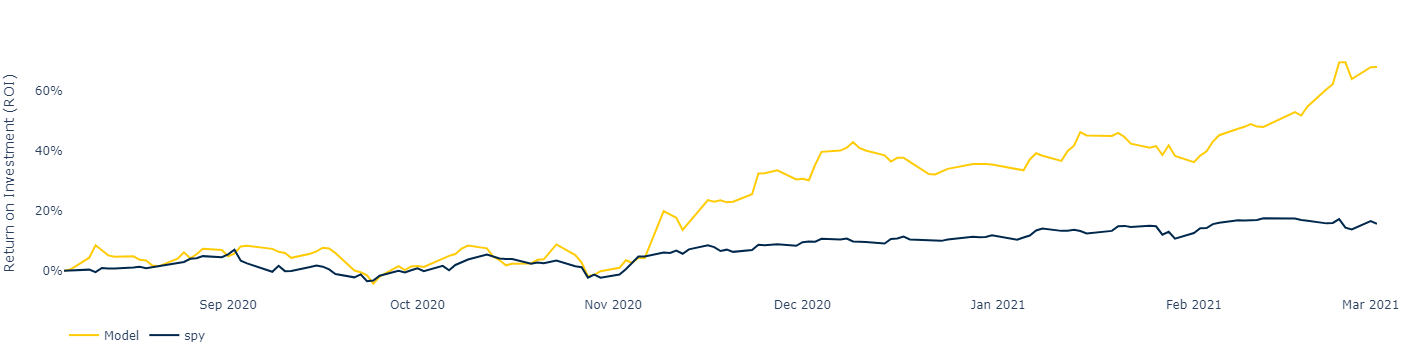

In [160]:
performance_chart(track_df, 'spy')

#### Action Items
1. Other views: Portfolio Makeup by sector
2. Add fundamental features, P/E Ratio, etc
3. Look at trending over time of earnings and compare to 2014-2016 timeframe (maybe earnings were not consistent?)
4. Rebuild best model potentially with different reggressor or PCA (remove covariance) and de-dupe covariant features
5. Create a classification model based on buy/sell thresholds? (essentially moving the buy sell strategy into target variable)

In [155]:
# Test with a load
def import_open_positions():
    conn = connect(dbname = '697_temp', user = 'postgres', host = 'databasesec.cvhiyxfodl3e.us-east-2.rds.amazonaws.com', password = 'poRter!5067')
    cur = conn.cursor()
    query = "SELECT * FROM open_positions"
    data = pd.read_sql_query(query,conn)
    data = data.sort_values(['key', 'model'])
    return data
open_pos_df = import_open_positions().drop('index',axis=1)

open_pos_df.tail()


,key,Date,Ticker,Quantity,Basis,Purchase Price,Current Value,Last,% Gain,model
4315,Positions_2021-03-03,2020-08-06,DOW,20,795.666891,39.783345,1238.165202,61.908260,55.61,RF Reg_target_120_rebal_30_2017-01-01
4316,Positions_2021-03-03,2020-08-06,GILD,10,660.903695,66.090369,614.106095,61.410609,-7.08,RF Reg_target_120_rebal_30_2017-01-01
4317,Positions_2021-03-03,2020-08-06,INTC,14,666.889549,47.634968,840.980314,60.070022,26.10,RF Reg_target_120_rebal_30_2017-01-01
4318,Positions_2021-03-03,2020-08-06,MRK,8,601.330845,75.166356,548.197154,68.524644,-8.84,RF Reg_target_120_rebal_30_2017-01-01
4319,Positions_2021-03-03,2020-08-06,XOM,12,484.966866,40.413905,670.571104,55.880925,38.27,RF Reg_target_120_rebal_30_2017-01-01


In [158]:
open_pos_df.Date.unique()

array(['2020-08-06'], dtype=object)

In [ ]:
sector_plot(test.snapshots['Positions_2021-04-08'],test.snapshots['cash_2021-04-08'],date='2021-04-08')

In [9]:
def create_asset_view(hist_open_positions,remaining_cash,target,rebal_interval,train_start_dt):

    # Creating assets_df with current price on day of portfolio rebalancing
    asset_df = pd.DataFrame(columns=['Ticker','date','price','quantity','curr_val'])

    # Getting start and end of portfolio positions
    start_dt = list(hist_open_positions.keys())[0]
    end_dt = list(hist_open_positions.keys())[-1]

    # Creating list of dates we need to get current prices for
    date_list = list(port.tracking_df[(port.tracking_df.index>=start_dt)&(port.tracking_df.index<=end_dt)].index)

    # Loop through all dates in hist_open_positions and add to assets_df with curr price
    for date in date_list:

        temp_df = pd.DataFrame.from_dict(get_curr_portfolio_value(hist_open_positions,port,date.strftime('%Y-%m-%d')),orient='index')\
                                    .reset_index().rename(columns={'index':'Ticker'})

        asset_df = asset_df.append(temp_df)

    # sum all ticker position values for a given day
    cum_df = asset_df.groupby('date')[['curr_val']].sum()

    # Getting remaining cash by trade day
    rem_cash_df = pd.DataFrame.from_dict(remaining_cash,orient='index',columns=['cash_remaining'])
    rem_cash_df.index = rem_cash_df.index.strftime('%Y-%m-%d')

    # Combining stock and cash value into single df; forward filling since cash_df only has cash on trade days
    comb_df = cum_df.merge(rem_cash_df,how='left',left_index=True,right_index=True).fillna(method="ffill")
    comb_df['Total Assets'] = comb_df['curr_val'] + comb_df['cash_remaining']

    # Creating a returning figure
    fig_3 = go.Figure()

    # Adding line for cash invested - Will need to be updated for different buying strategies
    y_len = len(port.hist_trades_df['Date'].unique())

    fig_3.add_trace(go.Scatter(x=port.hist_trades_df['Date'].unique(),y=[10000 for x in range(y_len)],name='Cash Invested'))

    fig_3.add_trace(go.Scatter(x=comb_df.index,y=comb_df['Total Assets'].values,name='Total Assets'))

    # Adding first stacked area for stock value
    fig_3.add_trace(go.Scatter(
        x=comb_df.index, y=comb_df['curr_val'].values,
        hoverinfo='x+y',
        mode='lines',
        line=dict(width=0.5, color='rgb(131, 90, 241)'),
        stackgroup='one', # define stack group
        name='Total Stock Value'
    ))

    # Adding second stacked area for case value
    fig_3.add_trace(go.Scatter(
        x=comb_df.index, y=comb_df['cash_remaining'].values,
        hoverinfo='x+y',
        mode='lines',
        line=dict(width=0.5, color='gray'),
        stackgroup='one', # define stack group
        name='Cash on Hand'
    ))

    fig_3.update_layout(yaxis_range=(0, 20000))

    fig_3.update_layout(width = 950, height = 300,
                        margin=dict(l=20, r=20, t=50, b=10),
                        paper_bgcolor='white',
                        plot_bgcolor='white',
                        legend=dict( orientation="h"),
                        yaxis_tickformat = '$.2s',
                        title= dict(text=f'Total Assets ($k) for Target = {target}, Rebal = {rebal_interval}, Train Start = {train_start_dt}', font = dict(size = 20, color = 'black'), x = 0.5, y = 0.96))

    return fig_3

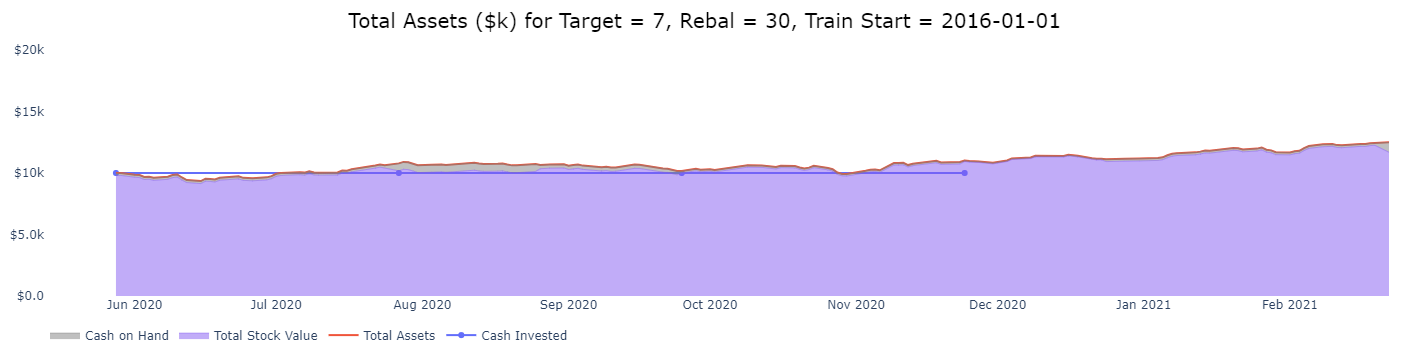

In [343]:
# Asset view for Target = 7 Days and Rebal_Interval = 30 Days and Train Start = 2016-01-01
create_asset_view(run_df2.iloc[1]['hist_open_positions'],run_df2.iloc[1]['remaining_cash'],\
                 run_df2.iloc[1]['target'],run_df2.iloc[1]['rebal_interval'],run_df2.iloc[1]['train_start_dt'])